### Instructions


It is highly recommended that you run this notebook in Colab.


Please install the libraries below.


Please upload the following files from the prepped_data folder in the repo into the folder of your running Colab notebook:
- ser-labels-paths(1).csv
- mfccs3_data.npy


Then you can proceed to run through the cells.


In [ ]:
# !pip install ffmpeg
# !pip install kagglehub
# !pip install librosa
# !pip install pydub
# !pip install evaluate
# !pip install pycaret
# !pip install tensorflow
# import evaluate
# !pip install pipreqsnb

import glob
import IPython.display as ipd
import kagglehub
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib as Path
import pickle
import soundfile as sf
import seaborn as sns
import torch
import tensorflow as tf

# from evaluate import load
from pathlib import Path
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModel
from transformers import TFAutoModelForAudioClassification
from transformers import HubertForCTC, AutoProcessor
from transformers import pipeline, EarlyStoppingCallback
from transformers import TrainingArguments, Trainer

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


In [ ]:
df = pd.read_csv('/content/ser-labels-paths (1).csv',index_col=False) #import df

In [ ]:
df.head()

,labels,paths
0,suprised,/kaggle/input/ravdess-emotional-speech-audio/A...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/A...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/A...


In [ ]:
X_mfcc = np.load('./mfccs3_data.npy', allow_pickle=True)

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(13602, 40)

In [ ]:
# input split
X = np.expand_dims(X, -1)
X.shape
# 3 dimensional 1. Length of dataset, 2. Column length (should be 40 as that is the number of features we are extracting in our mfccs) 3. Dimension length

(13602, 40, 1, 1)

In [ ]:
# Output column
encoder = OneHotEncoder()
le = LabelEncoder()

In [ ]:
y_encoded = encoder.fit_transform(df[['labels']])
y_encoded

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13602 stored elements and shape (13602, 8)>

In [ ]:
y = y_encoded.toarray()
y.shape

(13602, 8)

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

In [ ]:
# build model
model_LSTM1 = Sequential([
    LSTM(123,return_sequences=False, input_shape=(40,1)), #this is the number of freatures we extracted from each observation
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax'),
])

model_LSTM1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM1.summary()
tf.keras.models.save_model(model_LSTM1, 'lstm1_model.h5')

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 123)            │        61,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,780 (280.39 KB)

 Trainable params: 71,780 (280.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_LSTM1.fit(X_test, y_test, validation_split=0.2, epochs=100, batch_size=512, shuffle=True)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.1348 - loss: 2.0621 - val_accuracy: 0.1670 - val_loss: 2.0232
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.1686 - loss: 2.0232 - val_accuracy: 0.1945 - val_loss: 1.9885
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.1895 - loss: 1.9872 - val_accuracy: 0.2055 - val_loss: 1.9511
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.1924 - loss: 1.9574 - val_accuracy: 0.2110 - val_loss: 1.9151
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.1994 - loss: 1.9301 - val_accuracy: 0.2459 - val_loss: 1.8847
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.2265 - loss: 1.8843 - val_accuracy: 0.2275 - val_loss: 1.8517
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.2217 - loss: 1.8542 - val_accuracy: 0.2220 - val_loss: 1.8349
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.2339 - loss: 1.8368 - val_accuracy: 0.2349 - v

In [ ]:
y_pred = np.asarray(model_LSTM1.predict(X_test)).argmax(axis=1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


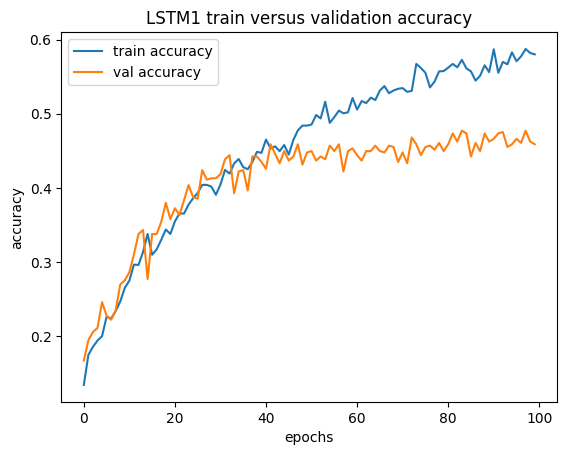

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.title('LSTM1 train versus validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show();
plt.savefig('LSTM1 train versus validation accuracy')

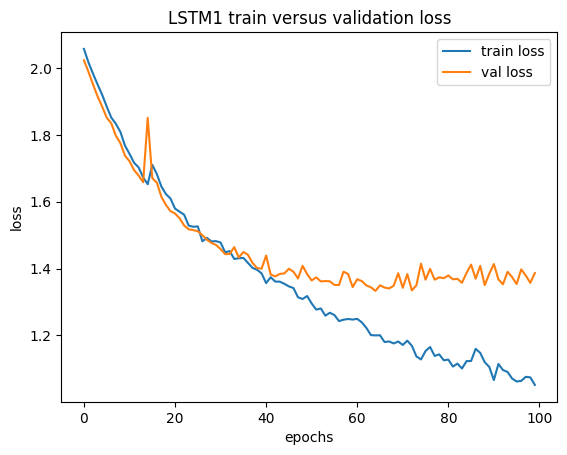

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = list(range(100))
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('LSTM1 train versus validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show();
plt.savefig('LSTM1 train versus validation loss')

In [ ]:
# adding early stopping into .fit()
early_stop2 = EarlyStopping(
      monitor='accuracy',  # Metric to monitor (e.g., validation loss)
      patience=10,          # Number of epochs with no improvement after which training will be stopped
      mode='min',          # 'min' for metrics that should decrease (like loss), 'max' for metrics that should increase (like accuracy)
      restore_best_weights=True # Restores model weights from the epoch with the best monitored value
    )

In [ ]:
# tweaking the model
model_LSTM2 = Sequential([
  Conv1D(64, kernel_size=3, activation='relu', input_shape=(40,1)),
  MaxPooling1D(pool_size=2),
  LSTM(128, return_sequences=False),
  Dense(64, activation='relu'),
  Dropout(0.2),
  Dense(8, activation='softmax'),
])

model_LSTM2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM2.summary()
tf.keras.models.save_model(model_LSTM2, 'lstm_model2.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 38, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,848 (421.28 KB)

 Trainable params: 107,848 (421.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history2 = model_LSTM2.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=512, shuffle=True, callbacks=[early_stop2])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.1690 - loss: 1.9864 - val_accuracy: 0.2719 - val_loss: 1.7917
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.2661 - loss: 1.7635 - val_accuracy: 0.3836 - val_loss: 1.5731
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.3604 - loss: 1.5790 - val_accuracy: 0.4093 - val_loss: 1.4710
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.3974 - loss: 1.4916 - val_accuracy: 0.4460 - val_loss: 1.4030
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.4347 - loss: 1.4339 - val_accuracy: 0.4548 - val_loss: 1.3626
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.4633 - loss: 1.3733 - val_accuracy: 0.4419 - val_loss: 1.3596
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.4707 - loss: 1.3427 - val_accuracy: 0.4571 - val_loss: 1.3358
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.4728 - loss: 1.3411 - val_accu

In [ ]:
y_pred2 = np.asarray(model_LSTM2.predict(X_test)).argmax(axis=1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


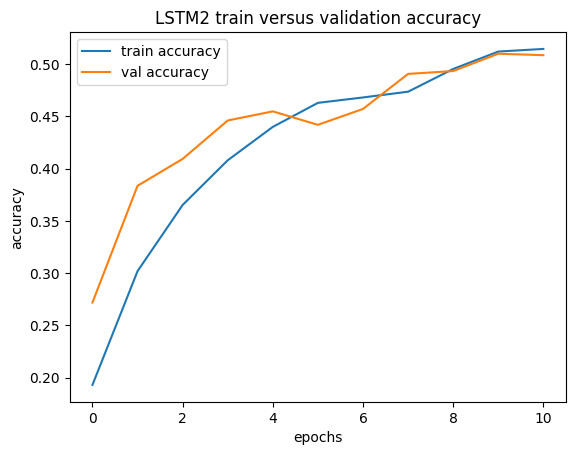

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = list(range(11))
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.title('LSTM2 train versus validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('LSTM2 train versus validation accuracy')

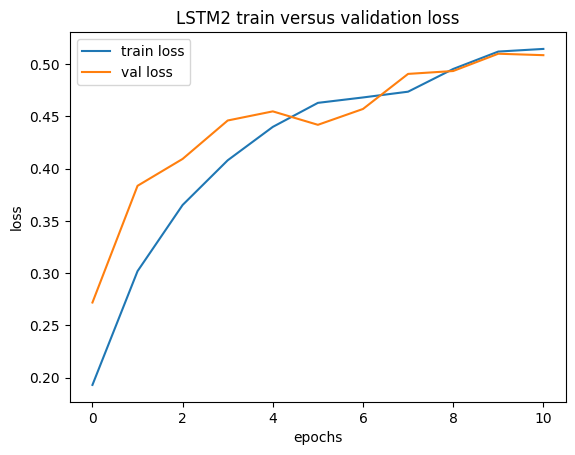

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = list(range(11))
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.plot(epochs, acc, label='train loss')
plt.plot(epochs, val_acc, label='val loss')
plt.title('LSTM2 train versus validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.savefig('LSTM2 train versus validation loss')

In [ ]:
# LSTM3
model_LSTM3 = Sequential([
    LSTM(123,return_sequences=False, input_shape=(40,1)), #this is the number of freatures we extracted from each observation
    Dense(72, activation='relu'), #increased
    Dropout(0.2),
    Dense(24, activation='relu'), #decreased
    Dropout(0.3),
    Dense(8, activation='softmax'),
])

model_LSTM3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM3.summary()
tf.keras.models.save_model(model_LSTM3, 'lstm3_model.h5')

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 123)            │        61,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 72)             │         8,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 24)             │         1,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,380 (282.73 KB)

 Trainable params: 72,380 (282.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history3 = model_LSTM3.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=512, shuffle=True, callbacks=[early_stop2])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.1229 - loss: 2.0738 - val_accuracy: 0.2269 - val_loss: 1.9785
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.1877 - loss: 1.9878 - val_accuracy: 0.2480 - val_loss: 1.8714
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.2209 - loss: 1.9049 - val_accuracy: 0.3211 - val_loss: 1.7526
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.2766 - loss: 1.7964 - val_accuracy: 0.3601 - val_loss: 1.6586
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.3003 - loss: 1.7295 - val_accuracy: 0.3831 - val_loss: 1.6121
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.3335 - loss: 1.6758 - val_accuracy: 0.3771 - val_loss: 1.5489
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.3544 - loss: 1.6097 - val_accuracy: 0.4180 - val_loss: 1.4788
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.3790 - loss: 1.5544 - val_accu

In [ ]:
y_pred3 = np.asarray(model_LSTM3.predict(X_test)).argmax(axis=1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


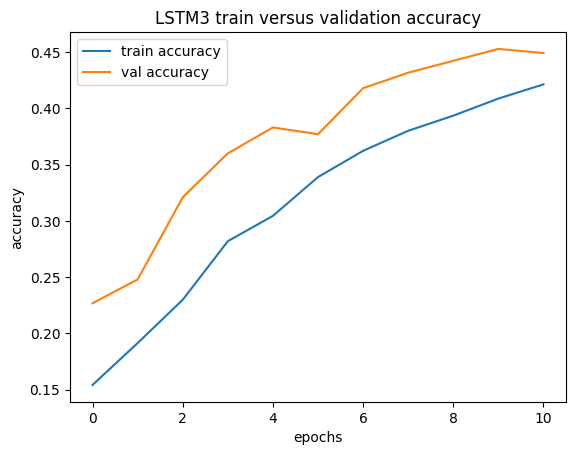

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = list(range(11))
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.title('LSTM3 train versus validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show();
plt.savefig('LSTM3 train versus validation accuracy')

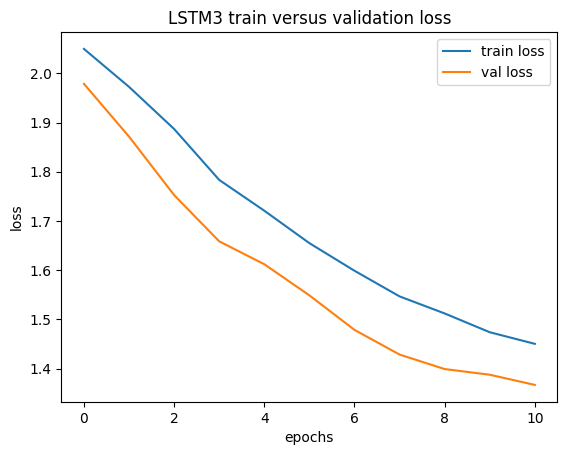

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = list(range(11))
loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('LSTM3 train versus validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show();
plt.savefig('LSTM3 train versus validation loss')

In [ ]:
# LSTM4
model_LSTM4 = Sequential([
  Conv1D(64, kernel_size=3, activation='relu', input_shape=(40,1)),
  MaxPooling1D(pool_size=2),
  LSTM(128, return_sequences=False),
  Dense(64, activation='relu'),
  Dropout(0.2),
  Dense(32, activation='relu'),  #added
  Dropout(0.2), #added
  Dense(8, activation='softmax'),
])

model_LSTM4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM4.summary()
tf.keras.models.save_model(model_LSTM4, 'lstm4_model.h5')

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 38, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,672 (428.41 KB)

 Trainable params: 109,672 (428.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history4 = model_LSTM4.fit(X_test, y_test, validation_split=0.2, epochs=100, batch_size=512, shuffle=True)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.1466 - loss: 2.0679 - val_accuracy: 0.1670 - val_loss: 1.9659
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.1632 - loss: 1.9954 - val_accuracy: 0.1780 - val_loss: 1.9362
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.1959 - loss: 1.9629 - val_accuracy: 0.2349 - val_loss: 1.8980
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.2187 - loss: 1.9131 - val_accuracy: 0.2165 - val_loss: 1.8559
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.2469 - loss: 1.8509 - val_accuracy: 0.2330 - val_loss: 1.8143
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.2528 - loss: 1.8240 - val_accuracy: 0.2716 - val_loss: 1.7682
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.2899 - loss: 1.7631 - val_accuracy: 0.2789 - val_loss: 1.7407
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.2949 - loss: 1.7284 - val_accuracy: 0.3229 - v

In [ ]:
y_pred4 = np.asarray(model_LSTM4.predict(X_test)).argmax(axis=1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


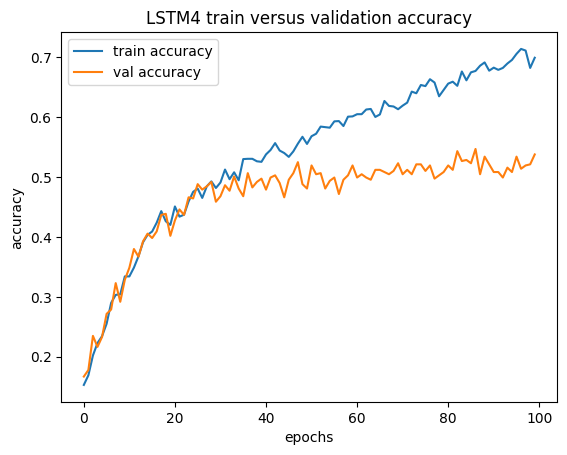

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = list(range(100))
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.title('LSTM4 train versus validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('LSTM4 train versus validation accuracy')

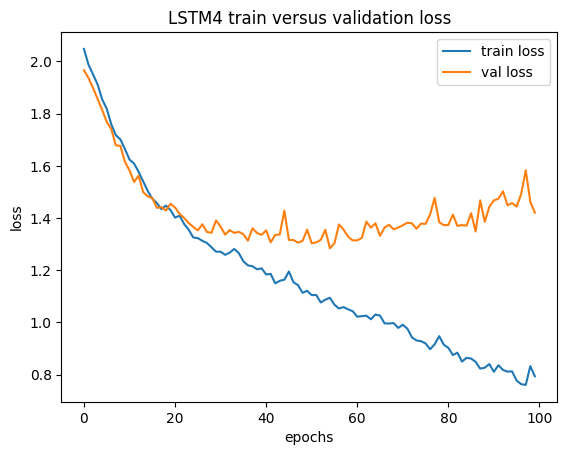

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = list(range(100))
loss = history4.history['loss']
val_loss = history4.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('LSTM4 train versus validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.savefig('LSTM4 train versus validation loss')

###